# A Nonlinear Time Dependent Problem
Now we can set up our PDE model
As an example we will study the Forchheimer problem
<cite data-cite="Kieu"></cite>
which is a scalar, nonlinear parabolic equation
\begin{equation}
\partial_tu - \nabla\cdot K(\nabla u)\nabla u = f
\end{equation}
where the diffusion tensor is given by
\begin{equation}
K(\nabla u) = \frac{2}{1+\sqrt{1+4|\nabla u|}}
\end{equation}
and $f=f(x,t)$ is some time dependent forcing term.
On the boundary we prescribe Neumann boundary as before
and initial conditions $u=u_0$.

We will solve this problem in variational form and using Crank Nicholson in time
\begin{equation}
\begin{split}
\int_{\Omega} \frac{u^{n+1}-u^n}{\Delta t} \varphi
+ \frac{1}{2}K(\nabla u^{n+1}) \nabla u^{n+1} \cdot \nabla \varphi \
+ \frac{1}{2}K(\nabla u^n) \nabla u^n \cdot \nabla \varphi v\ dx \\
- \int_{\Omega} \frac{1}{2}(f(x,t^n)+f(x,t^n+\Delta t) \varphi\ dx
- \int_{\partial \Omega} \frac{1}{2}(g(x,t^n)+g(x,t^n+\Delta t)) v\ ds
= 0.
\end{split}
\end{equation}
on a domain $\Omega=[0,1]^2$. We choose $f,g$ so that the exact solution
is given by
\begin{align*}
u(x,t) = e^{-2t}\left(\frac{1}{2}(x^2 + y^2) - \frac{1}{3}(x^3 - y^3)\right) + 1
\end{align*}

In [1]:
import matplotlib
matplotlib.rc( 'image', cmap='jet' )
import math, sys, io

from dune.grid import structuredGrid as leafGridView
from dune.fem.space import lagrange as solutionSpace
from dune.fem.scheme import galerkin as solutionScheme
from dune.fem.function import gridFunction, cppFunction, integrate, uflFunction
from dune.ufl import DirichletBC, Constant
from ufl import TestFunction, TrialFunction, SpatialCoordinate, FacetNormal, \
                dx, ds, div, grad, dot, inner, sqrt, exp, sin

gridView = leafGridView([0, 0], [1, 1], [10, 10])
space = solutionSpace(gridView, order=2)

x = SpatialCoordinate(space)
initial = 1/2*(x[0]**2+x[1]**2) - 1/3*(x[0]**3 - x[1]**3) + 1
exact   = lambda t: exp(-2*t)*(initial - 1) + 1

u_h   = space.interpolate(initial, name='u_h')
u_h_n = u_h.copy(name="previous")

u = TrialFunction(space)
v = TestFunction(space)
dt = Constant(0, name="dt")    # time step
t  = Constant(0, name="t")     # current time

abs_du = lambda u: sqrt(inner(grad(u), grad(u)))
K = lambda u: 2/(1 + sqrt(1 + 4*abs_du(u)))
a = ( dot((u - u_h_n)/dt, v) \
    + 0.5*dot(K(u)*grad(u), grad(v)) \
    + 0.5*dot(K(u_h_n)*grad(u_h_n), grad(v)) ) * dx

f = lambda s: -2*exp(-2*s)*(initial - 1) - div( K(exact(s))*grad(exact(s)) )
g = lambda s: K(exact(s))*grad(exact(s))
n = FacetNormal(space)
b = 0.5*(f(t)+f(t+dt))*v*dx + 0.5*dot(g(t)+g(t+dt),n)*v*ds

With the model described as a ufl form, we can construct a scheme class
that provides the solve method which we can use to evolve the solution from
one time step to the next:

In [2]:
scheme = solutionScheme(a == b, solver='cg')

Optionally, we may want to increase the default quadrature orders which are
'2 * space.order' for element integrals and '2 * space.order + 1' for surface
integrals. Depending on the data this might not be enough. Then we simply
set the integration orders by hand like in the following example, by calling
the method setQuadratureOrders(interiorOrder, surfaceOrder).

In [3]:
#scheme.setQuadratureOrders( 2*space.order, 2*space.order+1 )

Since we have forced the system towards a given solution, we can compute
the discretization error. First we define ufl expressions for the $L^2$
and $H^1$ norms and will use those to compute the experimental order of
convergence of the scheme by computing the time evolution on different grid
levels.

In [4]:
endTime    = 0.25
exact_end  = exact(endTime)
l2error = uflFunction(gridView, name="l2error", order=u_h.space.order, ufl=dot(u_h - exact_end, u_h - exact_end))
h1error = uflFunction(gridView, name="h1error", order=u_h.space.order, ufl=dot(grad(u_h - exact_end), grad(u_h - exact_end)))

Now we evolve the solution from time $t=0$ to $t=T$ in a loop. Since the
PDE model has time dependent coefficient (through the forcing term), we
need to update the `t` constant used to define the model before each step.
A second constant we used to define the model was `dt` which defines the
time step. We keep this constant and set it to $0.002$ at the beginning
of the simulation. This value could be changed in each time step:

grid size: 100
	 | u_h - u | = 8.26004e-06
	 | grad(uh - u) | = 6.39420e-04


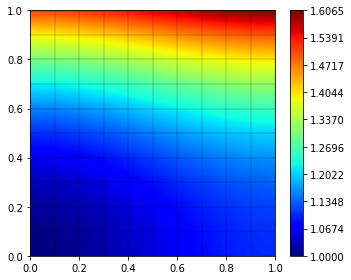

In [5]:
scheme.model.dt = 0.002
u_h.interpolate(initial)
time = 0
while time < (endTime - 1e-6):
    scheme.model.t = time
    u_h_n.assign(u_h)
    scheme.solve(target=u_h)
    time += scheme.model.dt

errors = [sqrt(e) for e in integrate(gridView, [l2error,h1error], order=5)]
print('grid size:', gridView.size(0))
print('\t | u_h - u | =', '{:0.5e}'.format(errors[0]))
print('\t | grad(uh - u) | =', '{:0.5e}'.format(errors[1]))
u_h.plot()
gridView.writeVTK('forchheimer', pointdata={'u': u_h, 'l2error': l2error, 'h1error': h1error})